In [14]:
import numpy as np
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
import cvxopt
import copy

In [2]:
#state space
ss = np.zeros(shape=(10,10))
k=0
for i in range(0,10):
    for j in range(0,10):
        ss[j][i]=k
        k=k+1

In [3]:
#action set
action=("R","L","U","D")
gamma=0.8

In [4]:
right= np.zeros(shape=(100,100))
w=0.1
for i in range(0,100):
    if(i%10==0):
        right[i][i]+=w/4
    else:
        right[i][i-1]=w/4
    if(i-10<0):
        right[i][i]+=w/4
    else:
        right[i][i-10]=w/4
    if(i+10>99):
        right[i][i]+=w/4
    else:
        right[i][i+10]=1-w+w/4
    if((i+1)%10==0):
        right[i][i]+=w/4
    else:
        right[i][i+1]=w/4
    if(i+10>99):                      #extra condition for handling out of bound to the right side
        right[i][i]+=1-w

In [5]:
up= np.zeros(shape=(100,100))
w=0.1
for i in range(0,100):
    if(i%10==0):
        up[i][i]+=w/4
    else:
        up[i][i-1]=1-w+w/4
    if(i-10<0):
        up[i][i]+=w/4
    else:
        up[i][i-10]=w/4
    if(i+10>99):
        up[i][i]+=w/4
    else:
        up[i][i+10]=w/4
    if((i+1)%10==0):
        up[i][i]+=w/4
    else:
        up[i][i+1]=w/4
    if(i%10==0):                      #extra condition for handling out of bound to the up side
        up[i][i]+=1-w
    

In [6]:
left= np.zeros(shape=(100,100))
w=0.1
for i in range(0,100):
    if(i%10==0):
        left[i][i]+=w/4
    else:
        left[i][i-1]=w/4
    if(i-10<0):
        left[i][i]+=w/4
    else:
        left[i][i-10]=1-w+w/4
    if(i+10>99):
        left[i][i]+=w/4
    else:
        left[i][i+10]=w/4
    if((i+1)%10==0):
        left[i][i]+=w/4
    else:
        left[i][i+1]=w/4
    if(i-10<0):                      #extra condition for handling out of bound to the left side
        left[i][i]+=1-w
    

In [7]:
down= np.zeros(shape=(100,100))
w=0.1
for i in range(0,100):
    if(i%10==0):
        down[i][i]+=w/4
    else:
        down[i][i-1]=w/4
    if(i-10<0):
        down[i][i]+=w/4
    else:
        down[i][i-10]=w/4
    if(i+10>99):
        down[i][i]+=w/4
    else:
        down[i][i+10]=w/4
    if((i+1)%10==0):
        down[i][i]+=w/4
    else:
        down[i][i+1]=1-w+w/4
    if((i+1)%10==0):                      #extra condition for handling out of bound to the down side
        down[i][i]+=1-w
    

In [8]:
rf1=np.zeros(shape=(10, 10))
rf1[9,9]=1.0
rf1
rf2=np.matrix([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
 [ 0,  0,  0,  0,  -100,  -100,  -100,  0,  0,  0],
 [ 0,  0,  0,  0,  -100,  0,  -100,  0,  0,  0],
 [ 0,  0,  0,  0,  -100,  0,  -100,  -100,  -100,  0],
 [ 0,  0,  0,  0,  -100,  0,  0,  0,  -100,  0],
 [ 0,  0,  0,  0,  -100,  0,  0,  0,  -100,  0],
 [ 0,  0,  0,  0,  -100,  0,  0,  0,  -100,  0],
 [ 0,  0,  0,  0,  0,  0,  -100,  -100,  -100,  0],
 [ 0,  0,  0,  0,  0,  0,  -100,  0,  0,  0],
 [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  10]])

In [9]:
def optimal_value(ss,action,w,gamma,reward_func,right,left,up,down):
    v=np.zeros(100)
    delta=3
    r=np.asarray(np.transpose(reward_func)).reshape(-1)
    while(delta>0.01):
        delta=0
        v1=np.copy(v)
        for s in range(0,100):
            temp=v1[s]
            up_temp=np.sum(up[s]*(r+gamma*v1))
            down_temp=np.sum(down[s]*(r+gamma*v1))
            right_temp=np.sum(right[s]*(r+gamma*v1))
            left_temp=np.sum(left[s]*(r+gamma*v1))
            #print up_temp,"  ",down_temp,"  ",right_temp, "  ",left_temp
            v[s]=max(up_temp,down_temp,right_temp,left_temp)
            delta=max(delta,abs(temp-v[s]))
        #print delta
    return v

In [10]:
def optimal_policy(ss,action,w,gamma,reward_func,right,left,up,down):
    v=np.zeros(100)
    delta=float("inf")
    r=np.asarray(np.transpose(reward_func)).reshape(-1)
    policy=np.zeros(100)
    arrows=np.zeros(100) # ("R","L","U","D")
    while(delta>0.01):
        delta=0
        v1=copy.copy(v)
        for s in range(0,100):
            temp=v1[s]
            up_temp=np.sum(up[s]*(r+gamma*v1))
            down_temp=np.sum(down[s]*(r+gamma*v1))
            right_temp=np.sum(right[s]*(r+gamma*v1))
            left_temp=np.sum(left[s]*(r+gamma*v1))
            #print up_temp,"  ",down_temp,"  ",right_temp, "  ",left_temp
            v[s]=max(up_temp,down_temp,right_temp,left_temp)
            delta=max(delta,abs(temp-v[s]))
    for s in range(0,100):
        up_temp=np.sum(up[s]*(r+gamma*v))
        down_temp=np.sum(down[s]*(r+gamma*v))
        right_temp=np.sum(right[s]*(r+gamma*v))
        left_temp=np.sum(left[s]*(r+gamma*v))
        arr=[right_temp,left_temp,up_temp,down_temp]
        policy[s]=np.amax(arr)
        arrows[s]=arr.index(np.amax(arr))
    return policy,arrows
        

In [11]:
def getarrows(a):
    #arrow=np.chararray(100)
    arrow = ["" for x in range(100)]
    for i in range(0,100):
        if( a[i]==0):
            arrow[i]=u'\u2192'
        elif(a[i]==1):
            arrow[i]=u'\u2190'
        elif(a[i]==2):
            arrow[i]=u'\u2191'
        elif(a[i]==3):
            arrow[i]=u'\u2193'
    #print arrow
    return arrow


In [12]:
alist = [right, left, up, down]

def getzeros(x,y):
    return np.zeros(shape=(x,y))

In [15]:
v1,Oe1=optimal_policy(ss,action,w,gamma,rf1,right,left,up,down)
v2,Oe2=optimal_policy(ss,action,w,gamma,rf2,right,left,up,down)

maximum = [1,10]
rf = [rf1,rf2]
Oe = [Oe1, Oe2]

In [16]:
def getmatrices(Oe,alist,ind,gamma,lamb,maximum):
    I = np.identity(100)
    mat1 = getzeros(300,100)
    iden_mat = getzeros(300,100)
    i=0
    for s in range(100):
        opt = int(Oe[ind][s])
        for action in range(len(alist)):
            if(opt==action):
                continue
            pa1 = alist[opt]
            pa = alist[action]
            mat1[i,:] = np.matmul((pa1[s]-pa[s]).reshape(1,100), np.linalg.inv(I-gamma*pa1))
            iden_mat[i,s] = 1
            i=i+1

    mat1 = -mat1

    R = np.vstack((mat1, mat1,-I, I, I, -I))
    t = np.vstack((iden_mat, getzeros(700,100)))
    u = np.vstack((getzeros(600,100), -I, -I, getzeros(200,100)))
    D = np.hstack((R,t,u))
    #print(D.shape)

    ones = getzeros(100,1)+1
    C = np.vstack((getzeros(100,1), ones, -lamb*ones))
    #print(C.shape)
    B = getzeros(800,1)
    Rmax = getzeros(100,1)+maximum[ind]
    B = np.vstack((B, Rmax, Rmax))
    #print(B.shape)
    mat1 = -mat1
    return C,D,B

def getrewardfunc(C,D,B):
    C = cvxopt.matrix(C)
    D = cvxopt.matrix(D)
    B = cvxopt.matrix(B)
    sol = solvers.lp(C,D,B)
    R = sol['x'][:100]
    return R

def getaccuracy(Oa,ind):
    acc=0
    for j in range(len(Oa)):
        if(Oa[j]==Oe[ind][j]):
            acc = acc+1

    acc = acc/100.0
    return acc

def getheatmap(M):
    ax = sns.heatmap(M)
    plt.show()

In [18]:
#Q11,18
lambd_list = np.arange(0,5.01,0.01)
#lambd_list = [1,2,3]
acc_list_list = []
I = np.identity(100)
ind = 0   
while(ind<2):
    acc_list = []
    for lamb in lambd_list:
        C,D,B = getmatrices(Oe,alist,ind,gamma,lamb,maximum)
        R = getrewardfunc(C,D,B)
        
        v12,Oa=optimal_policy(ss,action,w,gamma,R,right,left,up,down)
        
        acc = getaccuracy(Oa, ind)
        acc_list.append(acc)
    acc_list_list.append(acc_list)
    ind = ind+1
    

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.1238e+02  2e+03  2e+00  2e+01  1e+00
 1: -1.3368e+02 -2.7811e+02  1e+03  1e+00  8e+00  1e+00
 2: -4.8063e+02 -6.3197e+02  3e+03  1e+00  9e+00  3e+00
 3: -4.7980e+03 -5.0283e+03  3e+04  2e+00  1e+01  2e+01
 4: -2.8752e+05 -2.8672e+05  2e+06  2e+00  1e+01  1e+03
 5: -2.8773e+07 -2.8670e+07  2e+08  2e+00  1e+01  1e+05
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.1238e+02  2e+03  2e+00  2e+01  1e+00
 1: -1.3514e+02 -2.8011e+02  1e+03  1e+00  8e+00  1e+00
 2: -4.8811e+02 -6.4015e+02  3e+03  1e+00  9e+00  3e+00
 3: -4.8179e+03 -5.0489e+03  3e+04  2e+00  1e+01  2e+01
 4: -2.8859e+05 -2.8779e+05  2e+06  2e+00  1e+01  1e+03
 5: -2.8880e+07 -2.8778e+07  2e+08  2e+00  1e+01  1e+05
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.1238e+02  2e+03  2e+00  2e+01  1e+00
 1: -1.3663e+02 -2.8216e+02 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.1238e+02  2e+03  2e+00  2e+01  1e+00
 1: -1.6557e+02 -3.2930e+02  2e+03  1e+00  9e+00  2e+00
 2: -6.7126e+02 -8.4312e+02  4e+03  1e+00  1e+01  3e+00
 3: -5.3333e+03 -5.5859e+03  4e+04  2e+00  2e+01  2e+01
 4: -3.0162e+05 -3.0083e+05  2e+06  2e+00  1e+01  1e+03
 5: -3.0187e+07 -3.0085e+07  2e+08  2e+00  1e+01  1e+05
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.1238e+02  2e+03  2e+00  2e+01  1e+00
 1: -1.6726e+02 -3.3248e+02  2e+03  1e+00  9e+00  2e+00
 2: -6.8219e+02 -8.5540e+02  4e+03  1e+00  1e+01  4e+00
 3: -5.3765e+03 -5.6307e+03  4e+04  2e+00  2e+01  2e+01
 4: -3.0334e+05 -3.0254e+05  2e+06  2e+00  1e+01  1e+03
 5: -3.0358e+07 -3.0256e+07  2e+08  2e+00  1e+01  1e+05
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.1238e+02  2e+03  2e+00  2e+01  1e+00
 1: -1.6900e+02 -3.3572e+02 

 3: -9.1889e+03 -9.4664e+03  7e+04  2e+00  2e+01  3e+01
 4: -6.9058e+05 -6.8866e+05  5e+06  2e+00  1e+01  2e+03
 5: -6.9088e+07 -6.8868e+07  5e+08  2e+00  1e+01  2e+05
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.1238e+02  2e+03  2e+00  2e+01  1e+00
 1: -2.0807e+02 -4.0556e+02  2e+03  1e+00  1e+01  2e+00
 2: -9.1751e+02 -1.1217e+03  6e+03  1e+00  1e+01  4e+00
 3: -9.2444e+03 -9.5237e+03  7e+04  2e+00  2e+01  3e+01
 4: -6.9461e+05 -6.9268e+05  5e+06  2e+00  1e+01  2e+03
 5: -6.9491e+07 -6.9270e+07  5e+08  2e+00  1e+01  2e+05
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.1238e+02  2e+03  2e+00  2e+01  1e+00
 1: -2.1074e+02 -4.1017e+02  2e+03  1e+00  1e+01  2e+00
 2: -9.3102e+02 -1.1372e+03  6e+03  2e+00  1e+01  4e+00
 3: -9.3156e+03 -9.5967e+03  7e+04  2e+00  2e+01  3e+01
 4: -7.0054e+05 -6.9859e+05  5e+06  2e+00  1e+01  2e+03
 5: -7.0084e+07 -6.9862e+0

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.1238e+02  2e+03  2e+00  2e+01  1e+00
 1: -2.7031e+02 -5.0947e+02  3e+03  2e+00  1e+01  2e+00
 2: -1.3882e+03 -1.6525e+03  1e+04  2e+00  1e+01  6e+00
 3: -1.3775e+04 -1.4073e+04  1e+05  2e+00  2e+01  5e+01
 4: -1.1842e+06 -1.1808e+06  8e+06  2e+00  2e+01  4e+03
 5: -1.1846e+08 -1.1808e+08  8e+08  2e+00  2e+01  4e+05
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.1238e+02  2e+03  2e+00  2e+01  1e+00
 1: -2.7435e+02 -5.1601e+02  3e+03  2e+00  1e+01  2e+00
 2: -1.4378e+03 -1.7074e+03  1e+04  2e+00  1e+01  6e+00
 3: -1.4331e+04 -1.4628e+04  1e+05  2e+00  2e+01  5e+01
 4: -1.2469e+06 -1.2433e+06  9e+06  2e+00  2e+01  4e+03
 5: -1.2473e+08 -1.2434e+08  9e+08  2e+00  2e+01  4e+05
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.1238e+02  2e+03  2e+00  2e+01  1e+00
 1: -2.7848e+02 -5.2268e+02 

 2: -1.9817e+03 -2.3480e+03  2e+04  3e+00  2e+01  8e+00
 3: -4.2295e+04 -4.2491e+04  3e+05  2e+00  1e+01  1e+02
 4: -4.2411e+06 -4.2291e+06  3e+07  2e+00  1e+01  1e+04
 5: -4.2415e+08 -4.2292e+08  3e+09  2e+00  1e+01  1e+06
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.2789e+02  2e+03  2e+00  1e+01  1e+00
 1: -3.5131e+02 -6.4281e+02  4e+03  2e+00  1e+01  2e+00
 2: -2.0181e+03 -2.3908e+03  2e+04  3e+00  2e+01  8e+00
 3: -4.2506e+04 -4.2702e+04  3e+05  2e+00  1e+01  1e+02
 4: -4.2667e+06 -4.2547e+06  3e+07  2e+00  1e+01  1e+04
 5: -4.2671e+08 -4.2548e+08  3e+09  2e+00  1e+01  1e+06
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.2889e+02  2e+03  2e+00  1e+01  1e+00
 1: -3.5558e+02 -6.4978e+02  4e+03  2e+00  1e+01  2e+00
 2: -2.0560e+03 -2.4353e+03  2e+04  3e+00  2e+01  9e+00
 3: -4.2758e+04 -4.2954e+04  3e+05  2e+00  1e+01  1e+02
 4: -4.2950e+06 -4.2830e+0

 2: -3.2405e+03 -3.8251e+03  4e+04  4e+00  2e+01  1e+01
 3: -4.8994e+04 -4.9231e+04  3e+05  2e+00  2e+01  1e+02
 4: -4.9375e+06 -4.9231e+06  3e+07  2e+00  2e+01  1e+04
 5: -4.9380e+08 -4.9232e+08  3e+09  2e+00  2e+01  1e+06
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.4789e+02  2e+03  2e+00  1e+01  1e+00
 1: -4.6072e+02 -8.2238e+02  6e+03  2e+00  1e+01  3e+00
 2: -3.3553e+03 -3.9594e+03  4e+04  4e+00  2e+01  2e+01
 3: -4.9666e+04 -4.9907e+04  3e+05  3e+00  2e+01  2e+02
 4: -5.0055e+06 -4.9907e+06  3e+07  3e+00  2e+01  2e+04
 5: -5.0060e+08 -4.9909e+08  3e+09  3e+00  2e+01  2e+06
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.4889e+02  2e+03  2e+00  1e+01  1e+00
 1: -4.6740e+02 -8.3320e+02  6e+03  2e+00  1e+01  3e+00
 2: -3.4797e+03 -4.1049e+03  5e+04  4e+00  3e+01  2e+01
 3: -5.0424e+04 -5.0669e+04  4e+05  3e+00  2e+01  2e+02
 4: -5.0821e+06 -5.0671e+0

 4: -3.7766e+06 -3.7644e+06  3e+07  3e+00  2e+01  1e+04
 5: -3.7772e+08 -3.7645e+08  3e+09  3e+00  2e+01  1e+06
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.6689e+02  2e+03  2e+00  1e+01  1e+00
 1: -6.0323e+02 -1.0522e+03  9e+03  3e+00  2e+01  3e+00
 2: -4.3193e+03 -5.2850e+03  8e+04  6e+00  4e+01  2e+01
 3: -3.7696e+04 -3.8081e+04  3e+05  3e+00  2e+01  1e+02
 4: -3.7915e+06 -3.7792e+06  3e+07  3e+00  2e+01  1e+04
 5: -3.7921e+08 -3.7793e+08  3e+09  3e+00  2e+01  1e+06
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.6789e+02  2e+03  2e+00  1e+01  1e+00
 1: -6.0868e+02 -1.0623e+03  9e+03  3e+00  2e+01  3e+00
 2: -4.3511e+03 -5.3255e+03  8e+04  6e+00  4e+01  3e+01
 3: -3.7851e+04 -3.8241e+04  3e+05  3e+00  2e+01  1e+02
 4: -3.8064e+06 -3.7941e+06  3e+07  3e+00  2e+01  1e+04
 5: -3.8070e+08 -3.7942e+08  3e+09  3e+00  2e+01  1e+06
Certificate of dual infeas

 2: -4.9161e+03 -6.0481e+03  1e+05  7e+00  4e+01  3e+01
 3: -4.0633e+04 -4.1087e+04  4e+05  3e+00  2e+01  1e+02
 4: -4.0802e+06 -4.0666e+06  4e+07  3e+00  2e+01  1e+04
 5: -4.0810e+08 -4.0667e+08  4e+09  3e+00  2e+01  1e+06
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.8689e+02  2e+03  2e+00  1e+01  1e+00
 1: -7.1630e+02 -1.2592e+03  1e+04  3e+00  2e+01  4e+00
 2: -4.9469e+03 -6.0876e+03  1e+05  7e+00  4e+01  3e+01
 3: -4.0787e+04 -4.1245e+04  4e+05  3e+00  2e+01  1e+02
 4: -4.0954e+06 -4.0817e+06  4e+07  3e+00  2e+01  1e+04
 5: -4.0961e+08 -4.0819e+08  4e+09  3e+00  2e+01  1e+06
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.8789e+02  2e+03  2e+00  1e+01  1e+00
 1: -7.2213e+02 -1.2698e+03  1e+04  3e+00  2e+01  4e+00
 2: -4.9777e+03 -6.1271e+03  1e+05  7e+00  4e+01  3e+01
 3: -4.0941e+04 -4.1403e+04  4e+05  4e+00  2e+01  1e+02
 4: -4.1106e+06 -4.0968e+0

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -4.0589e+02  2e+03  2e+00  1e+01  1e+00
 1: -8.2895e+02 -1.4600e+03  1e+04  3e+00  2e+01  4e+00
 2: -5.5167e+03 -6.8216e+03  1e+05  7e+00  4e+01  3e+01
 3: -4.3673e+04 -4.4198e+04  4e+05  4e+00  2e+01  2e+02
 4: -4.3805e+06 -4.3654e+06  4e+07  4e+00  2e+01  2e+04
 5: -4.3813e+08 -4.3656e+08  4e+09  4e+00  2e+01  2e+06
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -4.0689e+02  2e+03  2e+00  1e+01  1e+00
 1: -8.3495e+02 -1.4706e+03  1e+04  4e+00  2e+01  4e+00
 2: -5.5457e+03 -6.8591e+03  1e+05  7e+00  4e+01  4e+01
 3: -4.3822e+04 -4.4350e+04  4e+05  4e+00  2e+01  2e+02
 4: -4.3952e+06 -4.3801e+06  4e+07  4e+00  2e+01  2e+04
 5: -4.3960e+08 -4.3803e+08  4e+09  4e+00  2e+01  2e+06
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -4.0789e+02  2e+03  2e+00  1e+01  1e+00
 1: -8.4096e+02 -1.4811e+03 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -4.2589e+02  2e+03  2e+00  1e+01  1e+00
 1: -9.4939e+02 -1.6688e+03  2e+04  4e+00  2e+01  5e+00
 2: -6.0742e+03 -7.5453e+03  1e+05  8e+00  4e+01  4e+01
 3: -4.6580e+04 -4.7172e+04  5e+05  4e+00  2e+01  2e+02
 4: -4.6689e+06 -4.6525e+06  4e+07  4e+00  2e+01  2e+04
 5: -4.6698e+08 -4.6527e+08  4e+09  4e+00  2e+01  2e+06
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -4.2689e+02  2e+03  2e+00  1e+01  1e+00
 1: -9.5539e+02 -1.6791e+03  2e+04  4e+00  2e+01  5e+00
 2: -6.1010e+03 -7.5801e+03  1e+05  8e+00  4e+01  4e+01
 3: -4.6724e+04 -4.7320e+04  5e+05  4e+00  2e+01  2e+02
 4: -4.6833e+06 -4.6668e+06  5e+07  4e+00  2e+01  2e+04
 5: -4.6842e+08 -4.6670e+08  5e+09  4e+00  2e+01  2e+06
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -4.2789e+02  2e+03  2e+00  1e+01  1e+00
 1: -9.6140e+02 -1.6893e+03 

 0:  0.0000e+00 -4.4489e+02  2e+03  2e+00  1e+01  1e+00
 1: -1.0628e+03 -1.8600e+03  2e+04  4e+00  2e+01  5e+00
 2: -6.5576e+03 -8.1770e+03  2e+05  8e+00  4e+01  4e+01
 3: -4.9240e+04 -4.9894e+04  5e+05  4e+00  2e+01  2e+02
 4: -4.9339e+06 -4.9163e+06  5e+07  4e+00  2e+01  2e+04
 5: -4.9349e+08 -4.9165e+08  5e+09  4e+00  2e+01  2e+06
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -4.4589e+02  2e+03  2e+00  1e+01  1e+00
 1: -1.0687e+03 -1.8698e+03  2e+04  4e+00  2e+01  5e+00
 2: -6.5815e+03 -8.2084e+03  2e+05  8e+00  4e+01  4e+01
 3: -4.9375e+04 -5.0032e+04  5e+05  4e+00  2e+01  2e+02
 4: -4.9474e+06 -4.9298e+06  5e+07  4e+00  2e+01  2e+04
 5: -4.9484e+08 -4.9299e+08  5e+09  4e+00  2e+01  2e+06
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -4.4689e+02  2e+03  2e+00  1e+01  1e+00
 1: -1.0746e+03 -1.8795e+03  2e+04  4e+00  2e+01  5e+00
 2: -6.6052e+03 -8.2395e+0

 1: -1.1734e+03 -2.0415e+03  2e+04  4e+00  2e+01  5e+00
 2: -6.9840e+03 -8.7394e+03  2e+05  9e+00  4e+01  5e+01
 3: -5.1720e+04 -5.2434e+04  5e+05  4e+00  2e+01  2e+02
 4: -5.1817e+06 -5.1630e+06  5e+07  4e+00  2e+01  2e+04
 5: -5.1828e+08 -5.1632e+08  5e+09  4e+00  2e+01  2e+06
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -4.6489e+02  3e+03  2e+00  1e+01  1e+00
 1: -1.1792e+03 -2.0507e+03  2e+04  4e+00  2e+01  5e+00
 2: -7.0048e+03 -8.7670e+03  2e+05  9e+00  4e+01  5e+01
 3: -5.1846e+04 -5.2563e+04  5e+05  4e+00  2e+01  2e+02
 4: -5.1942e+06 -5.1755e+06  5e+07  4e+00  2e+01  2e+04
 5: -5.1954e+08 -5.1757e+08  5e+09  4e+00  2e+01  2e+06
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -4.6589e+02  3e+03  2e+00  1e+01  1e+00
 1: -1.1849e+03 -2.0600e+03  2e+04  4e+00  2e+01  5e+00
 2: -7.0254e+03 -8.7944e+03  2e+05  9e+00  4e+01  5e+01
 3: -5.1971e+04 -5.2691e+0

 1: -1.2860e+03 -2.2210e+03  2e+04  4e+00  2e+01  6e+00
 2: -7.3691e+03 -9.2532e+03  2e+05  9e+00  4e+01  5e+01
 3: -5.4139e+04 -5.4915e+04  6e+05  5e+00  2e+01  2e+02
 4: -5.4238e+06 -5.4041e+06  6e+07  5e+00  2e+01  2e+04
 5: -5.4250e+08 -5.4044e+08  6e+09  5e+00  2e+01  2e+06
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -4.8489e+02  3e+03  2e+00  1e+01  1e+00
 1: -1.2915e+03 -2.2297e+03  2e+04  4e+00  2e+01  6e+00
 2: -7.3867e+03 -9.2768e+03  2e+05  9e+00  4e+01  5e+01
 3: -5.4255e+04 -5.5034e+04  6e+05  5e+00  2e+01  2e+02
 4: -5.4354e+06 -5.4157e+06  6e+07  5e+00  2e+01  2e+04
 5: -5.4366e+08 -5.4160e+08  6e+09  5e+00  2e+01  2e+06
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -4.8589e+02  3e+03  2e+00  1e+01  1e+00
 1: -1.2970e+03 -2.2383e+03  2e+04  4e+00  2e+01  6e+00
 2: -7.4041e+03 -9.3002e+03  2e+05  9e+00  4e+01  5e+01
 3: -5.4371e+04 -5.5153e+0

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -5.0389e+02  3e+03  2e+00  1e+01  1e+00
 1: -1.3940e+03 -2.3888e+03  3e+04  4e+00  2e+01  6e+00
 2: -7.6920e+03 -9.6899e+03  2e+05  9e+00  4e+01  5e+01
 3: -5.6381e+04 -5.7217e+04  6e+05  5e+00  2e+01  2e+02
 4: -5.6484e+06 -5.6279e+06  6e+07  5e+00  2e+01  2e+04
 5: -5.6497e+08 -5.6281e+08  6e+09  5e+00  2e+01  2e+06
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -5.0489e+02  3e+03  2e+00  1e+01  1e+00
 1: -1.3993e+03 -2.3969e+03  3e+04  4e+00  2e+01  6e+00
 2: -7.7067e+03 -9.7098e+03  2e+05  9e+00  4e+01  5e+01
 3: -5.6489e+04 -5.7328e+04  6e+05  5e+00  2e+01  2e+02
 4: -5.6592e+06 -5.6387e+06  6e+07  5e+00  2e+01  2e+04
 5: -5.6605e+08 -5.6389e+08  6e+09  5e+00  2e+01  2e+06
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -5.0589e+02  3e+03  2e+00  1e+01  1e+00
 1: -1.4046e+03 -2.4049e+03 

 3: -5.8373e+04 -5.9265e+04  6e+05  5e+00  2e+01  2e+02
 4: -5.8476e+06 -5.8263e+06  6e+07  5e+00  2e+01  2e+04
 5: -5.8490e+08 -5.8266e+08  6e+09  5e+00  2e+01  2e+06
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -5.2389e+02  3e+03  2e+00  1e+01  1e+00
 1: -1.4976e+03 -2.5456e+03  3e+04  4e+00  2e+01  6e+00
 2: -7.9599e+03 -1.0058e+04  2e+05  9e+00  4e+01  5e+01
 3: -5.8474e+04 -5.9369e+04  6e+05  5e+00  2e+01  2e+02
 4: -5.8575e+06 -5.8362e+06  6e+07  5e+00  2e+01  2e+04
 5: -5.8589e+08 -5.8365e+08  6e+09  5e+00  2e+01  2e+06
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -5.2489e+02  3e+03  2e+00  1e+01  1e+00
 1: -1.5027e+03 -2.5531e+03  3e+04  4e+00  2e+01  6e+00
 2: -7.9720e+03 -1.0074e+04  2e+05  9e+00  4e+01  5e+01
 3: -5.8576e+04 -5.9474e+04  6e+05  5e+00  2e+01  2e+02
 4: -5.8674e+06 -5.8460e+06  6e+07  5e+00  2e+01  2e+04
 5: -5.8688e+08 -5.8463e+0

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -5.4289e+02  3e+03  2e+00  1e+01  1e+00
 1: -1.5922e+03 -2.6855e+03  3e+04  5e+00  2e+01  6e+00
 2: -8.1717e+03 -1.0353e+04  2e+05  9e+00  4e+01  6e+01
 3: -6.0351e+04 -6.1302e+04  6e+05  5e+00  2e+01  2e+02
 4: -6.0404e+06 -6.0184e+06  6e+07  5e+00  2e+01  2e+04
 5: -6.0419e+08 -6.0188e+08  6e+09  5e+00  2e+01  2e+06
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -5.4389e+02  3e+03  2e+00  1e+01  1e+00
 1: -1.5970e+03 -2.6927e+03  3e+04  5e+00  2e+01  6e+00
 2: -8.1818e+03 -1.0367e+04  2e+05  9e+00  4e+01  6e+01
 3: -6.0447e+04 -6.1401e+04  6e+05  5e+00  2e+01  2e+02
 4: -6.0497e+06 -6.0278e+06  6e+07  5e+00  2e+01  2e+04
 5: -6.0512e+08 -6.0281e+08  6e+09  5e+00  2e+01  2e+06
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -5.4489e+02  3e+03  2e+00  1e+01  1e+00
 1: -1.6019e+03 -2.6998e+03 

 0:  0.0000e+00 -5.6189e+02  3e+03  2e+00  1e+01  1e+00
 1: -1.6834e+03 -2.8180e+03  3e+04  5e+00  2e+01  6e+00
 2: -8.3502e+03 -1.0606e+04  2e+05  9e+00  4e+01  6e+01
 3: -6.2142e+04 -6.3148e+04  7e+05  5e+00  2e+01  2e+02
 4: -6.2139e+06 -6.1914e+06  7e+07  5e+00  2e+01  2e+04
 5: -6.2155e+08 -6.1917e+08  7e+09  5e+00  2e+01  2e+06
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -5.6289e+02  3e+03  2e+00  1e+01  1e+00
 1: -1.6881e+03 -2.8247e+03  3e+04  5e+00  2e+01  6e+00
 2: -8.3588e+03 -1.0618e+04  2e+05  9e+00  4e+01  6e+01
 3: -6.2235e+04 -6.3243e+04  7e+05  5e+00  2e+01  3e+02
 4: -6.2229e+06 -6.2003e+06  7e+07  5e+00  2e+01  2e+04
 5: -6.2245e+08 -6.2006e+08  7e+09  5e+00  2e+01  2e+06
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -5.6389e+02  3e+03  2e+00  1e+01  1e+00
 1: -1.6928e+03 -2.8315e+03  3e+04  5e+00  2e+01  6e+00
 2: -8.3674e+03 -1.0630e+0

 4: -6.3800e+06 -6.3569e+06  7e+07  5e+00  2e+01  2e+04
 5: -6.3817e+08 -6.3573e+08  7e+09  5e+00  2e+01  2e+06
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -5.8189e+02  3e+03  2e+00  9e+00  1e+00
 1: -1.7762e+03 -2.9505e+03  3e+04  5e+00  2e+01  7e+00
 2: -8.5108e+03 -1.0837e+04  2e+05  9e+00  4e+01  6e+01
 3: -6.3956e+04 -6.5020e+04  7e+05  5e+00  2e+01  3e+02
 4: -6.3886e+06 -6.3655e+06  7e+07  5e+00  2e+01  2e+04
 5: -6.3903e+08 -6.3658e+08  7e+09  5e+00  2e+01  2e+06
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -5.8289e+02  3e+03  2e+00  9e+00  1e+00
 1: -1.7808e+03 -2.9570e+03  3e+04  5e+00  2e+01  7e+00
 2: -8.5182e+03 -1.0847e+04  2e+05  9e+00  4e+01  6e+01
 3: -6.4045e+04 -6.5112e+04  7e+05  5e+00  2e+01  3e+02
 4: -6.3971e+06 -6.3740e+06  7e+07  5e+00  2e+01  2e+04
 5: -6.3988e+08 -6.3743e+08  7e+09  5e+00  2e+01  2e+06
Certificate of dual infeas

 2: -8.6447e+03 -1.1031e+04  2e+05  9e+00  4e+01  6e+01
 3: -6.5624e+04 -6.6743e+04  7e+05  5e+00  2e+01  3e+02
 4: -6.5482e+06 -6.5246e+06  7e+07  5e+00  2e+01  3e+04
 5: -6.5500e+08 -6.5250e+08  7e+09  5e+00  2e+01  3e+06
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -6.0189e+02  3e+03  2e+00  9e+00  1e+00
 1: -1.8663e+03 -3.0772e+03  3e+04  5e+00  2e+01  7e+00
 2: -8.6513e+03 -1.1041e+04  2e+05  9e+00  4e+01  6e+01
 3: -6.5710e+04 -6.6833e+04  7e+05  5e+00  2e+01  3e+02
 4: -6.5565e+06 -6.5328e+06  7e+07  5e+00  2e+01  3e+04
 5: -6.5582e+08 -6.5332e+08  7e+09  5e+00  2e+01  3e+06
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -6.0289e+02  3e+03  2e+00  9e+00  1e+00
 1: -1.8707e+03 -3.0834e+03  3e+04  5e+00  2e+01  7e+00
 2: -8.6580e+03 -1.1051e+04  2e+05  9e+00  4e+01  6e+01
 3: -6.5797e+04 -6.6922e+04  7e+05  5e+00  2e+01  3e+02
 4: -6.5647e+06 -6.5410e+0

 5: -6.7124e+08 -6.6868e+08  7e+09  5e+00  2e+01  3e+06
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -6.2189e+02  3e+03  2e+00  9e+00  1e+00
 1: -1.9541e+03 -3.1992e+03  3e+04  4e+00  2e+01  7e+00
 2: -8.7787e+03 -1.1228e+04  2e+05  9e+00  4e+01  6e+01
 3: -6.7415e+04 -6.8595e+04  7e+05  5e+00  2e+01  3e+02
 4: -6.7185e+06 -6.6943e+06  7e+07  5e+00  2e+01  3e+04
 5: -6.7203e+08 -6.6947e+08  7e+09  5e+00  2e+01  3e+06
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -6.2289e+02  3e+03  2e+00  9e+00  1e+00
 1: -1.9584e+03 -3.2052e+03  3e+04  4e+00  2e+01  7e+00
 2: -8.7848e+03 -1.1237e+04  2e+05  9e+00  4e+01  6e+01
 3: -6.7499e+04 -6.8682e+04  7e+05  5e+00  2e+01  3e+02
 4: -6.7264e+06 -6.7023e+06  7e+07  5e+00  2e+01  3e+04
 5: -6.7283e+08 -6.7027e+08  7e+09  5e+00  2e+01  3e+06
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres 

 0:  0.0000e+00 -6.4089e+02  3e+03  2e+00  9e+00  1e+00
 1: -2.0357e+03 -3.3115e+03  3e+04  4e+00  2e+01  7e+00
 2: -8.8926e+03 -1.1396e+04  2e+05  9e+00  4e+01  6e+01
 3: -6.8986e+04 -7.0221e+04  8e+05  5e+00  2e+01  3e+02
 4: -6.8669e+06 -6.8423e+06  7e+07  5e+00  2e+01  3e+04
 5: -6.8689e+08 -6.8428e+08  7e+09  5e+00  2e+01  3e+06
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -6.4189e+02  3e+03  2e+00  9e+00  1e+00
 1: -2.0399e+03 -3.3174e+03  3e+04  4e+00  2e+01  7e+00
 2: -8.8984e+03 -1.1404e+04  2e+05  9e+00  4e+01  6e+01
 3: -6.9067e+04 -7.0306e+04  8e+05  5e+00  2e+01  3e+02
 4: -6.8746e+06 -6.8500e+06  7e+07  5e+00  2e+01  3e+04
 5: -6.8765e+08 -6.8504e+08  7e+09  5e+00  2e+01  3e+06
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -6.4289e+02  3e+03  2e+00  9e+00  1e+00
 1: -2.0442e+03 -3.3232e+03  4e+04  4e+00  2e+01  7e+00
 2: -8.9043e+03 -1.1413e+0

 1: -2.1159e+03 -3.4211e+03  4e+04  4e+00  2e+01  7e+00
 2: -8.8416e+03 -1.1368e+04  2e+05  9e+00  3e+01  6e+01
 3: -6.9481e+04 -7.0774e+04  8e+05  5e+00  2e+01  3e+02
 4: -6.9040e+06 -6.8794e+06  8e+07  5e+00  2e+01  3e+04
 5: -6.9060e+08 -6.8798e+08  8e+09  5e+00  2e+01  3e+06
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -6.6089e+02  3e+03  2e+00  9e+00  1e+00
 1: -2.1201e+03 -3.4268e+03  4e+04  4e+00  2e+01  7e+00
 2: -8.8372e+03 -1.1364e+04  2e+05  9e+00  3e+01  6e+01
 3: -6.9497e+04 -7.0793e+04  8e+05  5e+00  2e+01  3e+02
 4: -6.9049e+06 -6.8803e+06  8e+07  5e+00  2e+01  3e+04
 5: -6.9069e+08 -6.8807e+08  8e+09  5e+00  2e+01  3e+06
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -6.6189e+02  3e+03  2e+00  9e+00  1e+00
 1: -2.1242e+03 -3.4325e+03  4e+04  4e+00  2e+01  7e+00
 2: -8.8328e+03 -1.1360e+04  2e+05  9e+00  3e+01  6e+01
 3: -6.9514e+04 -7.0813e+0

 0:  0.0000e+00 -6.7989e+02  4e+03  2e+00  9e+00  1e+00
 1: -2.1990e+03 -3.5340e+03  4e+04  4e+00  2e+01  7e+00
 2: -8.7573e+03 -1.1300e+04  2e+05  9e+00  3e+01  6e+01
 3: -6.9859e+04 -7.1215e+04  8e+05  5e+00  2e+01  3e+02
 4: -6.9267e+06 -6.9021e+06  8e+07  5e+00  2e+01  3e+04
 5: -6.9288e+08 -6.9026e+08  8e+09  5e+00  2e+01  3e+06
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -6.8089e+02  4e+03  2e+00  9e+00  1e+00
 1: -2.2031e+03 -3.5396e+03  4e+04  4e+00  2e+01  7e+00
 2: -8.7533e+03 -1.1297e+04  2e+05  9e+00  3e+01  6e+01
 3: -6.9881e+04 -7.1240e+04  8e+05  5e+00  2e+01  3e+02
 4: -6.9281e+06 -6.9035e+06  8e+07  5e+00  2e+01  3e+04
 5: -6.9302e+08 -6.9039e+08  8e+09  5e+00  2e+01  3e+06
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -6.8189e+02  4e+03  2e+00  9e+00  1e+00
 1: -2.2072e+03 -3.5452e+03  4e+04  4e+00  2e+01  7e+00
 2: -8.7493e+03 -1.1294e+0

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -6.9989e+02  4e+03  2e+00  9e+00  1e+00
 1: -2.2810e+03 -3.6449e+03  4e+04  4e+00  2e+01  7e+00
 2: -8.6816e+03 -1.1241e+04  2e+05  8e+00  3e+01  5e+01
 3: -7.0348e+04 -7.1767e+04  8e+05  5e+00  2e+01  3e+02
 4: -6.9590e+06 -6.9343e+06  8e+07  6e+00  2e+01  3e+04
 5: -6.9612e+08 -6.9348e+08  8e+09  6e+00  2e+01  3e+06
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -7.0089e+02  4e+03  2e+00  9e+00  1e+00
 1: -2.2851e+03 -3.6504e+03  4e+04  4e+00  2e+01  7e+00
 2: -8.6781e+03 -1.1238e+04  2e+05  8e+00  3e+01  5e+01
 3: -7.0375e+04 -7.1798e+04  8e+05  5e+00  2e+01  3e+02
 4: -6.9608e+06 -6.9362e+06  8e+07  6e+00  2e+01  3e+04
 5: -6.9630e+08 -6.9367e+08  8e+09  6e+00  2e+01  3e+06
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -7.0189e+02  4e+03  2e+00  8e+00  1e+00
 1: -2.2892e+03 -3.6559e+03 

 3: -7.0913e+04 -7.2395e+04  8e+05  5e+00  2e+01  3e+02
 4: -6.9985e+06 -6.9738e+06  8e+07  6e+00  2e+01  3e+04
 5: -7.0008e+08 -6.9743e+08  8e+09  6e+00  2e+01  3e+06
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -7.1989e+02  4e+03  2e+00  8e+00  1e+00
 1: -2.3621e+03 -3.7542e+03  4e+04  4e+00  2e+01  7e+00
 2: -8.6153e+03 -1.1192e+04  2e+05  8e+00  3e+01  5e+01
 3: -7.0946e+04 -7.2431e+04  8e+05  5e+00  2e+01  3e+02
 4: -7.0008e+06 -6.9761e+06  8e+07  6e+00  2e+01  3e+04
 5: -7.0031e+08 -6.9767e+08  8e+09  6e+00  2e+01  3e+06
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -7.2089e+02  4e+03  2e+00  8e+00  1e+00
 1: -2.3662e+03 -3.7597e+03  4e+04  4e+00  2e+01  7e+00
 2: -8.6123e+03 -1.1190e+04  2e+05  8e+00  3e+01  5e+01
 3: -7.0979e+04 -7.2467e+04  8e+05  5e+00  2e+01  3e+02
 4: -7.0032e+06 -6.9785e+06  8e+07  6e+00  2e+01  3e+04
 5: -7.0055e+08 -6.9790e+0

 2: -8.5613e+03 -1.1155e+04  2e+05  8e+00  3e+01  5e+01
 3: -7.1616e+04 -7.3166e+04  8e+05  6e+00  2e+01  3e+02
 4: -7.0494e+06 -7.0246e+06  8e+07  6e+00  2e+01  3e+04
 5: -7.0518e+08 -7.0252e+08  8e+09  6e+00  2e+01  3e+06
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -7.3989e+02  4e+03  2e+00  8e+00  1e+00
 1: -2.4425e+03 -3.8623e+03  4e+04  4e+00  2e+01  7e+00
 2: -8.5587e+03 -1.1153e+04  2e+05  8e+00  3e+01  5e+01
 3: -7.1654e+04 -7.3207e+04  8e+05  6e+00  2e+01  3e+02
 4: -7.0522e+06 -7.0274e+06  8e+07  6e+00  2e+01  3e+04
 5: -7.0546e+08 -7.0280e+08  8e+09  6e+00  2e+01  3e+06
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -7.4089e+02  4e+03  2e+00  8e+00  1e+00
 1: -2.4465e+03 -3.8677e+03  4e+04  4e+00  2e+01  7e+00
 2: -8.5562e+03 -1.1152e+04  2e+05  8e+00  3e+01  5e+01
 3: -7.1692e+04 -7.3249e+04  8e+05  6e+00  2e+01  3e+02
 4: -7.0550e+06 -7.0302e+0

 3: -4.1588e+03 -5.3977e+03  1e+04  9e-02  9e+00  5e+00
 4: -8.5990e+03 -9.9832e+03  3e+04  1e-01  1e+01  1e+01
 5: -6.0533e+04 -6.1783e+04  1e+05  1e-01  9e+00  7e+01
 6: -4.5724e+06 -4.5686e+06  1e+07  9e-02  9e+00  5e+03
 7: -4.5744e+08 -4.5692e+08  1e+09  9e-02  9e+00  5e+05
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.1067e+03  5e+03  2e-01  2e+01  1e+00
 1: -1.1793e+02 -1.2716e+03  2e+03  8e-02  8e+00  8e-01
 2: -1.0454e+03 -2.3143e+03  5e+03  9e-02  9e+00  2e+00
 3: -4.1627e+03 -5.4016e+03  1e+04  9e-02  9e+00  5e+00
 4: -8.6602e+03 -1.0046e+04  3e+04  1e-01  1e+01  1e+01
 5: -6.1370e+04 -6.2621e+04  2e+05  1e-01  9e+00  7e+01
 6: -4.6720e+06 -4.6681e+06  1e+07  9e-02  9e+00  5e+03
 7: -4.6740e+08 -4.6688e+08  1e+09  9e-02  9e+00  5e+05
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.1067e+03  5e+03  2e-01  2e+01  1e+00
 1: -1.1900e+02 -1.2730e+0

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.1067e+03  5e+03  2e-01  2e+01  1e+00
 1: -1.3573e+02 -1.2948e+03  2e+03  8e-02  8e+00  9e-01
 2: -1.1434e+03 -2.4117e+03  5e+03  9e-02  9e+00  2e+00
 3: -4.2643e+03 -5.5037e+03  1e+04  9e-02  9e+00  5e+00
 4: -9.8766e+03 -1.1290e+04  3e+04  1e-01  1e+01  1e+01
 5: -7.6861e+04 -7.8119e+04  2e+05  1e-01  9e+00  9e+01
 6: -6.5089e+06 -6.5031e+06  2e+07  1e-01  9e+00  7e+03
 7: -6.5110e+08 -6.5039e+08  2e+09  1e-01  9e+00  7e+05
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.1067e+03  5e+03  2e-01  2e+01  1e+00
 1: -1.3706e+02 -1.2965e+03  2e+03  8e-02  8e+00  9e-01
 2: -1.1519e+03 -2.4204e+03  5e+03  9e-02  9e+00  2e+00
 3: -4.2750e+03 -5.5145e+03  1e+04  9e-02  9e+00  5e+00
 4: -9.9853e+03 -1.1401e+04  3e+04  1e-01  1e+01  1e+01
 5: -7.7909e+04 -7.9168e+04  2e+05  1e-01  9e+00  9e+01
 6: -6.6239e+06 -6.6180e+06  2e+07  1e-01  9e+00  7e+03
 7: -6.6260

 4: -1.2216e+04 -1.3667e+04  4e+04  1e-01  1e+01  2e+01
 5: -1.0180e+05 -1.0308e+05  3e+05  1e-01  9e+00  1e+02
 6: -9.2147e+06 -9.2062e+06  2e+07  1e-01  9e+00  1e+04
 7: -9.2169e+08 -9.2070e+08  2e+09  1e-01  9e+00  1e+06
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.1067e+03  5e+03  2e-01  2e+01  1e+00
 1: -1.5947e+02 -1.3263e+03  2e+03  8e-02  8e+00  9e-01
 2: -1.3358e+03 -2.6162e+03  5e+03  9e-02  9e+00  2e+00
 3: -4.5461e+03 -5.7947e+03  1e+04  9e-02  8e+00  5e+00
 4: -1.2452e+04 -1.3906e+04  4e+04  1e-01  1e+01  2e+01
 5: -1.0472e+05 -1.0600e+05  3e+05  1e-01  9e+00  1e+02
 6: -9.5278e+06 -9.5190e+06  2e+07  1e-01  9e+00  1e+04
 7: -9.5300e+08 -9.5198e+08  2e+09  1e-01  9e+00  1e+06
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.1067e+03  5e+03  2e-01  2e+01  1e+00
 1: -1.6115e+02 -1.3286e+03  2e+03  8e-02  8e+00  9e-01
 2: -1.3535e+03 -2.6357e+0

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.1067e+03  5e+03  2e-01  2e+01  1e+00
 1: -1.8962e+02 -1.3670e+03  2e+03  8e-02  7e+00  9e-01
 2: -1.6983e+03 -3.0305e+03  6e+03  1e-01  8e+00  3e+00
 3: -5.1946e+03 -6.4992e+03  1e+04  9e-02  8e+00  6e+00
 4: -1.8325e+04 -1.9849e+04  5e+04  1e-01  1e+01  2e+01
 5: -1.7787e+05 -1.7918e+05  4e+05  1e-01  9e+00  2e+02
 6: -1.6977e+07 -1.6960e+07  4e+07  1e-01  9e+00  2e+04
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.1067e+03  5e+03  2e-01  2e+01  1e+00
 1: -1.9176e+02 -1.3699e+03  2e+03  8e-02  7e+00  9e-01
 2: -1.7124e+03 -3.0487e+03  6e+03  1e-01  8e+00  3e+00
 3: -5.2331e+03 -6.5424e+03  1e+04  9e-02  8e+00  6e+00
 4: -1.8622e+04 -2.0151e+04  5e+04  1e-01  1e+01  2e+01
 5: -1.7738e+05 -1.7870e+05  4e+05  1e-01  9e+00  2e+02
 6: -1.6907e+07 -1.6890e+07  4e+07  1e-01  9e+00  2e+04
Certificate of dual infeasibility found.
     pcost       dcost    

 3: -5.6582e+03 -7.2712e+03  2e+04  1e-01  9e+00  6e+00
 4: -2.1566e+04 -2.3356e+04  7e+04  1e-01  1e+01  2e+01
 5: -1.0126e+05 -1.0290e+05  3e+05  1e-01  1e+01  1e+02
 6: -8.2706e+06 -8.2624e+06  2e+07  1e-01  1e+01  1e+04
 7: -8.2727e+08 -8.2629e+08  2e+09  1e-01  1e+01  1e+06
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.1583e+03  5e+03  2e-01  2e+01  1e+00
 1: -2.3068e+02 -1.4404e+03  2e+03  9e-02  7e+00  9e-01
 2: -2.1013e+03 -3.8381e+03  9e+03  1e-01  1e+01  3e+00
 3: -5.6754e+03 -7.3259e+03  2e+04  1e-01  1e+01  6e+00
 4: -2.1536e+04 -2.3352e+04  7e+04  1e-01  1e+01  2e+01
 5: -1.0179e+05 -1.0344e+05  3e+05  1e-01  1e+01  1e+02
 6: -8.3177e+06 -8.3094e+06  2e+07  1e-01  1e+01  1e+04
 7: -8.3199e+08 -8.3099e+08  2e+09  1e-01  1e+01  1e+06
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.1683e+03  5e+03  2e-01  2e+01  1e+00
 1: -2.3286e+02 -1.4467e+0

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.3183e+03  5e+03  2e-01  2e+01  1e+00
 1: -2.6907e+02 -1.5466e+03  2e+03  9e-02  7e+00  1e+00
 2: -3.1114e+03 -5.8725e+03  2e+04  2e-01  1e+01  5e+00
 3: -6.8822e+03 -9.4779e+03  3e+04  2e-01  1e+01  1e+01
 4: -2.8453e+04 -3.0647e+04  9e+04  2e-01  1e+01  3e+01
 5: -2.4771e+05 -2.4937e+05  6e+05  1e-01  1e+01  3e+02
 6: -2.3870e+07 -2.3845e+07  6e+07  1e-01  1e+01  3e+04
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.3283e+03  5e+03  2e-01  2e+01  1e+00
 1: -2.7163e+02 -1.5542e+03  2e+03  9e-02  7e+00  1e+00
 2: -3.2089e+03 -6.0583e+03  2e+04  2e-01  2e+01  5e+00
 3: -7.1622e+03 -9.8406e+03  3e+04  2e-01  1e+01  1e+01
 4: -2.9186e+04 -3.1427e+04  1e+05  2e-01  1e+01  4e+01
 5: -4.9200e+05 -4.9334e+05  1e+06  1e-01  1e+01  5e+02
 6: -4.9002e+07 -4.8951e+07  1e+08  1e-01  1e+01  5e+04
Certificate of dual infeasibility found.
     pcost       dcost    

 3: -9.2765e+03 -1.2918e+04  5e+04  2e-01  2e+01  2e+01
 4: -3.3652e+04 -3.6300e+04  1e+05  2e-01  1e+01  5e+01
 5: -7.3457e+05 -7.3584e+05  2e+06  1e-01  1e+01  1e+03
 6: -7.3389e+07 -7.3293e+07  2e+08  1e-01  1e+01  1e+05
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.4983e+03  5e+03  2e-01  2e+01  1e+00
 1: -3.0063e+02 -1.8352e+03  3e+03  1e-01  7e+00  1e+00
 2: -4.5016e+03 -8.2667e+03  3e+04  2e-01  2e+01  7e+00
 3: -8.9771e+03 -1.2695e+04  5e+04  2e-01  2e+01  2e+01
 4: -3.3100e+04 -3.5738e+04  1e+05  2e-01  1e+01  5e+01
 5: -7.0342e+05 -7.0477e+05  2e+06  1e-01  1e+01  9e+02
 6: -7.0254e+07 -7.0164e+07  2e+08  1e-01  1e+01  9e+04
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.5083e+03  5e+03  2e-01  2e+01  1e+00
 1: -3.0312e+02 -1.8521e+03  3e+03  1e-01  8e+00  1e+00
 2: -4.5905e+03 -8.4134e+03  3e+04  2e-01  2e+01  7e+00
 3: -8.7209e+03 -1.2514e+0

 2: -5.6002e+03 -1.0128e+04  4e+04  3e-01  2e+01  8e+00
 3: -8.6026e+03 -1.3183e+04  6e+04  3e-01  2e+01  2e+01
 4: -2.9056e+04 -3.2119e+04  1e+05  2e-01  1e+01  5e+01
 5: -1.8816e+05 -1.9050e+05  5e+05  2e-01  1e+01  3e+02
 6: -1.6329e+07 -1.6308e+07  4e+07  2e-01  1e+01  2e+04
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.6783e+03  5e+03  2e-01  2e+01  1e+00
 1: -3.4810e+02 -2.1489e+03  3e+03  1e-01  8e+00  1e+00
 2: -5.6434e+03 -1.0200e+04  4e+04  3e-01  2e+01  8e+00
 3: -8.6747e+03 -1.3284e+04  6e+04  3e-01  2e+01  2e+01
 4: -2.9374e+04 -3.2455e+04  1e+05  2e-01  1e+01  5e+01
 5: -1.9221e+05 -1.9457e+05  5e+05  2e-01  1e+01  3e+02
 6: -1.6739e+07 -1.6718e+07  4e+07  2e-01  1e+01  2e+04
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.6883e+03  5e+03  2e-01  2e+01  1e+00
 1: -3.5074e+02 -2.1676e+03  3e+03  1e-01  8e+00  1e+00
 2: -5.6868e+03 -1.0270e+0

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.8483e+03  6e+03  2e-01  2e+01  1e+00
 1: -3.9655e+02 -2.4697e+03  4e+03  1e-01  9e+00  1e+00
 2: -6.4006e+03 -1.1396e+04  4e+04  3e-01  2e+01  9e+00
 3: -9.9724e+03 -1.5037e+04  6e+04  3e-01  2e+01  2e+01
 4: -3.5585e+04 -3.8959e+04  1e+05  2e-01  1e+01  5e+01
 5: -2.8486e+05 -2.8735e+05  8e+05  2e-01  1e+01  4e+02
 6: -2.6321e+07 -2.6288e+07  7e+07  2e-01  1e+01  4e+04
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.8583e+03  6e+03  2e-01  2e+01  1e+00
 1: -3.9963e+02 -2.4888e+03  4e+03  1e-01  9e+00  1e+00
 2: -6.4463e+03 -1.1466e+04  4e+04  3e-01  2e+01  9e+00
 3: -1.0052e+04 -1.5142e+04  6e+04  3e-01  2e+01  2e+01
 4: -3.5994e+04 -3.9384e+04  1e+05  2e-01  1e+01  5e+01
 5: -2.9191e+05 -2.9441e+05  8e+05  2e-01  1e+01  4e+02
 6: -2.7059e+07 -2.7025e+07  7e+07  2e-01  1e+01  4e+04
Certificate of dual infeasibility found.
     pcost       dcost    

 1: -4.5208e+02 -2.7982e+03  4e+03  1e-01  9e+00  1e+00
 2: -7.1929e+03 -1.2584e+04  5e+04  3e-01  2e+01  1e+01
 3: -1.1382e+04 -1.6868e+04  7e+04  3e-01  2e+01  3e+01
 4: -4.3260e+04 -4.6908e+04  1e+05  2e-01  1e+01  6e+01
 5: -4.4002e+05 -4.4259e+05  1e+06  2e-01  1e+01  6e+02
 6: -4.2593e+07 -4.2540e+07  1e+08  2e-01  1e+01  6e+04
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -4.0283e+03  6e+03  2e-01  2e+01  1e+00
 1: -4.5557e+02 -2.8177e+03  4e+03  1e-01  9e+00  1e+00
 2: -7.2404e+03 -1.2654e+04  5e+04  3e-01  2e+01  1e+01
 3: -1.1469e+04 -1.6978e+04  7e+04  3e-01  2e+01  3e+01
 4: -4.3764e+04 -4.7426e+04  1e+05  2e-01  1e+01  6e+01
 5: -4.5201e+05 -4.5458e+05  1e+06  2e-01  1e+01  6e+02
 6: -4.3843e+07 -4.3787e+07  1e+08  2e-01  1e+01  6e+04
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -4.0383e+03  6e+03  2e-01  2e+01  1e+00
 1: -4.5909e+02 -2.8374e+0

 2: -8.0112e+03 -1.3732e+04  5e+04  3e-01  2e+01  1e+01
 3: -1.2908e+04 -1.8763e+04  8e+04  3e-01  2e+01  3e+01
 4: -5.1301e+04 -5.5274e+04  2e+05  2e-01  1e+01  7e+01
 5: -8.2377e+05 -8.2617e+05  2e+06  2e-01  1e+01  1e+03
 6: -8.2093e+07 -8.1993e+07  2e+08  2e-01  1e+01  1e+05
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -4.1983e+03  6e+03  2e-01  1e+01  1e+00
 1: -5.1698e+02 -3.1598e+03  5e+03  1e-01  9e+00  2e+00
 2: -8.0600e+03 -1.3798e+04  5e+04  3e-01  2e+01  1e+01
 3: -1.3001e+04 -1.8876e+04  8e+04  3e-01  2e+01  3e+01
 4: -5.1708e+04 -5.5705e+04  2e+05  2e-01  1e+01  7e+01
 5: -8.3336e+05 -8.3578e+05  2e+06  2e-01  1e+01  1e+03
 6: -8.3035e+07 -8.2934e+07  2e+08  2e-01  1e+01  1e+05
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -4.2083e+03  6e+03  2e-01  1e+01  1e+00
 1: -5.2078e+02 -3.1803e+03  5e+03  1e-01  9e+00  2e+00
 2: -8.1088e+03 -1.3864e+0

 2: -8.8488e+03 -1.4853e+04  5e+04  3e-01  2e+01  1e+01
 3: -1.4540e+04 -2.0727e+04  8e+04  3e-01  2e+01  3e+01
 4: -5.8303e+04 -6.2690e+04  2e+05  2e-01  1e+01  8e+01
 5: -9.8121e+05 -9.8400e+05  3e+06  2e-01  1e+01  1e+03
 6: -9.7586e+07 -9.7470e+07  3e+08  2e-01  1e+01  1e+05
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -4.3683e+03  6e+03  2e-01  1e+01  1e+00
 1: -5.8516e+02 -3.5127e+03  5e+03  1e-01  1e+01  2e+00
 2: -8.8986e+03 -1.4918e+04  5e+04  3e-01  2e+01  1e+01
 3: -1.4639e+04 -2.0845e+04  8e+04  3e-01  2e+01  3e+01
 4: -5.8736e+04 -6.3146e+04  2e+05  2e-01  1e+01  8e+01
 5: -9.9073e+05 -9.9354e+05  3e+06  2e-01  1e+01  1e+03
 6: -9.8519e+07 -9.8403e+07  3e+08  2e-01  1e+01  1e+05
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -4.3783e+03  6e+03  2e-01  1e+01  1e+00
 1: -5.8942e+02 -3.5338e+03  5e+03  2e-01  1e+01  2e+00
 2: -8.9484e+03 -1.4984e+0

 4: -6.6494e+04 -7.1300e+04  2e+05  2e-01  1e+01  9e+01
 5: -1.1616e+06 -1.1647e+06  3e+06  2e-01  1e+01  1e+03
 6: -1.1540e+08 -1.1527e+08  3e+08  2e-01  1e+01  1e+05
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -4.5483e+03  7e+03  2e-01  1e+01  1e+00
 1: -6.6630e+02 -3.8984e+03  6e+03  2e-01  1e+01  2e+00
 2: -9.7992e+03 -1.6093e+04  5e+04  3e-01  2e+01  1e+01
 3: -1.6475e+04 -2.3012e+04  9e+04  3e-01  2e+01  3e+01
 4: -6.6958e+04 -7.1786e+04  2e+05  2e-01  1e+01  9e+01
 5: -1.1716e+06 -1.1747e+06  3e+06  2e-01  1e+01  1e+03
 6: -1.1640e+08 -1.1626e+08  3e+08  2e-01  1e+01  1e+05
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -4.5583e+03  7e+03  2e-01  1e+01  1e+00
 1: -6.7109e+02 -3.9202e+03  6e+03  2e-01  1e+01  2e+00
 2: -9.8490e+03 -1.6159e+04  5e+04  3e-01  2e+01  1e+01
 3: -1.6578e+04 -2.3134e+04  9e+04  3e-01  2e+01  3e+01
 4: -6.7424e+04 -7.2275e+0

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -4.7183e+03  7e+03  2e-01  1e+01  1e+00
 1: -7.5230e+02 -4.2762e+03  7e+03  2e-01  1e+01  2e+00
 2: -1.0648e+04 -1.7205e+04  6e+04  3e-01  2e+01  1e+01
 3: -1.8275e+04 -2.5127e+04  1e+05  3e-01  2e+01  4e+01
 4: -7.5303e+04 -8.0508e+04  3e+05  3e-01  2e+01  1e+02
 5: -1.3593e+06 -1.3626e+06  4e+06  2e-01  1e+01  2e+03
 6: -1.3509e+08 -1.3494e+08  4e+08  2e-01  1e+01  2e+05
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -4.7283e+03  7e+03  2e-01  1e+01  1e+00
 1: -7.5767e+02 -4.2989e+03  7e+03  2e-01  1e+01  2e+00
 2: -1.0698e+04 -1.7270e+04  6e+04  3e-01  2e+01  1e+01
 3: -1.8384e+04 -2.5254e+04  1e+05  3e-01  2e+01  4e+01
 4: -7.5823e+04 -8.1050e+04  3e+05  3e-01  2e+01  1e+02
 5: -1.3715e+06 -1.3748e+06  4e+06  2e-01  1e+01  2e+03
 6: -1.3631e+08 -1.3615e+08  4e+08  2e-01  1e+01  2e+05
Certificate of dual infeasibility found.
     pcost       dcost    

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -4.8883e+03  7e+03  2e-01  1e+01  1e+00
 1: -8.4853e+02 -4.6699e+03  7e+03  2e-01  1e+01  2e+00
 2: -1.1502e+04 -1.8297e+04  6e+04  3e-01  2e+01  1e+01
 3: -2.0178e+04 -2.7326e+04  1e+05  3e-01  2e+01  4e+01
 4: -8.4664e+04 -9.0227e+04  3e+05  3e-01  2e+01  1e+02
 5: -1.5846e+06 -1.5881e+06  5e+06  2e-01  1e+01  2e+03
 6: -1.5767e+08 -1.5749e+08  5e+08  2e-01  1e+01  2e+05
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -4.8983e+03  7e+03  2e-01  1e+01  1e+00
 1: -8.5454e+02 -4.6936e+03  7e+03  2e-01  1e+01  2e+00
 2: -1.1553e+04 -1.8360e+04  6e+04  3e-01  2e+01  1e+01
 3: -2.0294e+04 -2.7458e+04  1e+05  3e-01  2e+01  4e+01
 4: -8.5251e+04 -9.0835e+04  3e+05  3e-01  2e+01  1e+02
 5: -1.5995e+06 -1.6030e+06  5e+06  2e-01  1e+01  2e+03
 6: -1.5916e+08 -1.5898e+08  5e+08  2e-01  1e+01  2e+05
Certificate of dual infeasibility found.
     pcost       dcost    

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -5.0583e+03  7e+03  2e-01  1e+01  1e+00
 1: -9.5634e+02 -5.0824e+03  8e+03  2e-01  1e+01  2e+00
 2: -1.2359e+04 -1.9364e+04  6e+04  3e-01  2e+01  1e+01
 3: -2.2198e+04 -2.9618e+04  1e+05  3e-01  2e+01  4e+01
 4: -9.5298e+04 -1.0120e+05  3e+05  3e-01  2e+01  1e+02
 5: -1.8679e+06 -1.8714e+06  6e+06  3e-01  1e+01  2e+03
 6: -1.8609e+08 -1.8588e+08  5e+08  3e-01  1e+01  2e+05
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -5.0683e+03  7e+03  2e-01  1e+01  1e+00
 1: -9.6308e+02 -5.1073e+03  8e+03  2e-01  1e+01  2e+00
 2: -1.2409e+04 -1.9426e+04  6e+04  3e-01  2e+01  1e+01
 3: -2.2321e+04 -2.9756e+04  1e+05  3e-01  2e+01  4e+01
 4: -9.5970e+04 -1.0189e+05  3e+05  3e-01  2e+01  1e+02
 5: -1.8868e+06 -1.8903e+06  6e+06  3e-01  1e+01  2e+03
 6: -1.8799e+08 -1.8777e+08  6e+08  3e-01  1e+01  2e+05
Certificate of dual infeasibility found.
     pcost       dcost    

 4: -1.0756e+05 -1.1378e+05  4e+05  3e-01  2e+01  1e+02
 5: -2.2328e+06 -2.2363e+06  7e+06  3e-01  1e+01  3e+03
 6: -2.2271e+08 -2.2246e+08  7e+08  3e-01  1e+01  3e+05
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -5.2383e+03  8e+03  2e-01  1e+01  1e+00
 1: -1.0850e+03 -5.5435e+03  9e+03  2e-01  1e+01  2e+00
 2: -1.3267e+04 -2.0464e+04  6e+04  3e-01  2e+01  1e+01
 3: -2.4484e+04 -3.2168e+04  1e+05  3e-01  2e+01  4e+01
 4: -1.0835e+05 -1.1458e+05  4e+05  3e-01  2e+01  1e+02
 5: -2.2575e+06 -2.2610e+06  7e+06  3e-01  1e+01  3e+03
 6: -2.2519e+08 -2.2493e+08  7e+08  3e-01  1e+01  3e+05
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -5.2483e+03  8e+03  2e-01  1e+01  1e+00
 1: -1.0926e+03 -5.5700e+03  9e+03  2e-01  1e+01  3e+00
 2: -1.3318e+04 -2.0525e+04  6e+04  3e-01  2e+01  1e+01
 3: -2.4616e+04 -3.2313e+04  1e+05  3e-01  2e+01  4e+01
 4: -1.0914e+05 -1.1539e+0

 3: -2.6664e+04 -3.4562e+04  1e+05  3e-01  2e+01  5e+01
 4: -1.2197e+05 -1.2848e+05  4e+05  3e-01  2e+01  2e+02
 5: -2.7167e+06 -2.7200e+06  8e+06  3e-01  1e+01  3e+03
 6: -2.7125e+08 -2.7095e+08  8e+08  3e-01  1e+01  3e+05
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -5.4083e+03  8e+03  2e-01  1e+01  1e+00
 1: -1.2224e+03 -6.0064e+03  1e+04  2e-01  1e+01  3e+00
 2: -1.4126e+04 -2.1477e+04  6e+04  3e-01  2e+01  1e+01
 3: -2.6806e+04 -3.4716e+04  1e+05  3e-01  2e+01  5e+01
 4: -1.2290e+05 -1.2942e+05  4e+05  3e-01  2e+01  2e+02
 5: -2.7500e+06 -2.7533e+06  8e+06  3e-01  1e+01  3e+03
 6: -2.7459e+08 -2.7429e+08  8e+08  3e-01  1e+01  3e+05
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -5.4183e+03  8e+03  2e-01  1e+01  1e+00
 1: -1.2310e+03 -6.0346e+03  1e+04  2e-01  1e+01  3e+00
 2: -1.4177e+04 -2.1535e+04  6e+04  3e-01  2e+01  1e+01
 3: -2.6948e+04 -3.4871e+0

 2: -1.4935e+04 -2.2407e+04  7e+04  3e-01  2e+01  1e+01
 3: -2.9165e+04 -3.7269e+04  1e+05  3e-01  2e+01  5e+01
 4: -1.3926e+05 -1.4603e+05  4e+05  3e-01  2e+01  2e+02
 5: -3.3816e+06 -3.3845e+06  1e+07  3e-01  1e+01  4e+03
 6: -3.3792e+08 -3.3754e+08  1e+09  3e-01  1e+01  4e+05
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -5.5783e+03  8e+03  2e-01  1e+01  1e+00
 1: -1.3778e+03 -6.5012e+03  1e+04  2e-01  1e+01  3e+00
 2: -1.4986e+04 -2.2464e+04  7e+04  3e-01  2e+01  1e+01
 3: -2.9318e+04 -3.7435e+04  1e+05  3e-01  2e+01  5e+01
 4: -1.4039e+05 -1.4717e+05  4e+05  3e-01  2e+01  2e+02
 5: -3.4283e+06 -3.4312e+06  1e+07  3e-01  1e+01  4e+03
 6: -3.4260e+08 -3.4222e+08  1e+09  3e-01  1e+01  4e+05
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -5.5883e+03  8e+03  2e-01  1e+01  1e+00
 1: -1.3876e+03 -6.5314e+03  1e+04  2e-01  1e+01  3e+00
 2: -1.5036e+04 -2.2522e+0

 0:  0.0000e+00 -5.7383e+03  8e+03  2e-01  1e+01  1e+00
 1: -1.5436e+03 -7.0017e+03  1e+04  2e-01  1e+01  3e+00
 2: -1.5797e+04 -2.3376e+04  7e+04  3e-01  2e+01  2e+01
 3: -3.1895e+04 -4.0189e+04  1e+05  3e-01  2e+01  5e+01
 4: -1.6053e+05 -1.6754e+05  5e+05  3e-01  1e+01  2e+02
 5: -4.3366e+06 -4.3388e+06  1e+07  3e-01  1e+01  5e+03
 6: -4.3359e+08 -4.3311e+08  1e+09  3e-01  1e+01  5e+05
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -5.7483e+03  8e+03  2e-01  1e+01  1e+00
 1: -1.5546e+03 -7.0343e+03  1e+04  2e-01  1e+01  3e+00
 2: -1.5848e+04 -2.3433e+04  7e+04  3e-01  2e+01  2e+01
 3: -3.2064e+04 -4.0369e+04  1e+05  3e-01  2e+01  5e+01
 4: -1.6194e+05 -1.6896e+05  5e+05  3e-01  1e+01  2e+02
 5: -4.4054e+06 -4.4076e+06  1e+07  3e-01  1e+01  5e+03
 6: -4.4049e+08 -4.4000e+08  1e+09  3e-01  1e+01  5e+05
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -5.7583e+0

 3: -3.4910e+04 -4.3379e+04  1e+05  3e-01  2e+01  5e+01
 4: -1.8749e+05 -1.9471e+05  6e+05  3e-01  1e+01  2e+02
 5: -5.7879e+06 -5.7889e+06  2e+07  3e-01  1e+01  6e+03
 6: -5.7890e+08 -5.7827e+08  2e+09  3e-01  1e+01  6e+05
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -5.9183e+03  8e+03  2e-01  1e+01  1e+00
 1: -1.7571e+03 -7.6137e+03  1e+04  2e-01  1e+01  3e+00
 2: -1.6715e+04 -2.4388e+04  7e+04  3e-01  2e+01  2e+01
 3: -3.5097e+04 -4.3576e+04  1e+05  3e-01  2e+01  5e+01
 4: -1.8930e+05 -1.9654e+05  6e+05  3e-01  1e+01  2e+02
 5: -5.8959e+06 -5.8968e+06  2e+07  3e-01  1e+01  7e+03
 6: -5.8971e+08 -5.8907e+08  2e+09  3e-01  1e+01  6e+05
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -5.9283e+03  8e+03  2e-01  1e+01  1e+00
 1: -1.7699e+03 -7.6495e+03  1e+04  2e-01  1e+01  3e+00
 2: -1.6767e+04 -2.4444e+04  7e+04  3e-01  2e+01  2e+01
 3: -3.5286e+04 -4.3775e+0

 1: -1.9905e+03 -8.2500e+03  1e+04  2e-01  1e+01  4e+00
 2: -1.7592e+04 -2.5341e+04  7e+04  3e-01  1e+01  2e+01
 3: -3.8490e+04 -4.7136e+04  2e+05  3e-01  2e+01  6e+01
 4: -2.2532e+05 -2.3274e+05  7e+05  3e-01  1e+01  3e+02
 5: -8.2948e+06 -8.2934e+06  2e+07  3e-01  1e+01  9e+03
 6: -8.2979e+08 -8.2890e+08  2e+09  3e-01  1e+01  9e+05
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -6.0983e+03  9e+03  2e-01  1e+01  1e+00
 1: -2.0054e+03 -8.2895e+03  1e+04  2e-01  1e+01  4e+00
 2: -1.7644e+04 -2.5398e+04  7e+04  3e-01  1e+01  2e+01
 3: -3.8702e+04 -4.7358e+04  2e+05  3e-01  2e+01  6e+01
 4: -2.2780e+05 -2.3523e+05  7e+05  3e-01  1e+01  3e+02
 5: -8.4825e+06 -8.4809e+06  2e+07  3e-01  1e+01  9e+03
 6: -8.4857e+08 -8.4766e+08  2e+09  3e-01  1e+01  9e+05
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -6.1083e+03  9e+03  2e-01  1e+01  1e+00
 1: -2.0204e+03 -8.3292e+0

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -6.2683e+03  9e+03  2e-01  1e+01  1e+00
 1: -2.2796e+03 -9.0009e+03  2e+04  2e-01  1e+01  4e+00
 2: -1.8538e+04 -2.6365e+04  7e+04  3e-01  1e+01  2e+01
 3: -4.2577e+04 -5.1401e+04  2e+05  3e-01  2e+01  6e+01
 4: -2.6076e+05 -2.6843e+05  8e+05  3e-01  1e+01  3e+02
 5: -1.1011e+07 -1.1007e+07  3e+07  3e-01  1e+01  1e+04
 6: -1.1016e+09 -1.1004e+09  3e+09  3e-01  1e+01  1e+06
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -6.2783e+03  9e+03  2e-01  1e+01  1e+00
 1: -2.2971e+03 -9.0454e+03  2e+04  2e-01  1e+01  4e+00
 2: -1.8592e+04 -2.6422e+04  7e+04  3e-01  1e+01  2e+01
 3: -4.2822e+04 -5.1656e+04  2e+05  3e-01  2e+01  6e+01
 4: -2.6289e+05 -2.7057e+05  8e+05  3e-01  1e+01  3e+02
 5: -1.1188e+07 -1.1184e+07  3e+07  3e-01  1e+01  1e+04
 6: -1.1193e+09 -1.1181e+09  3e+09  3e-01  1e+01  1e+06
Certificate of dual infeasibility found.
     pcost       dcost    

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -6.4583e+03  9e+03  2e-01  1e+01  1e+00
 1: -2.6441e+03 -9.9036e+03  2e+04  3e-01  1e+01  4e+00
 2: -1.9557e+04 -2.7497e+04  7e+04  3e-01  1e+01  2e+01
 3: -4.7504e+04 -5.6550e+04  2e+05  3e-01  2e+01  6e+01
 4: -3.0504e+05 -3.1297e+05  9e+05  3e-01  1e+01  3e+02
 5: -1.4994e+07 -1.4987e+07  4e+07  3e-01  1e+01  2e+04
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -6.4683e+03  9e+03  2e-01  1e+01  1e+00
 1: -2.6653e+03 -9.9549e+03  2e+04  3e-01  1e+01  4e+00
 2: -1.9612e+04 -2.7558e+04  7e+04  3e-01  1e+01  2e+01
 3: -4.7785e+04 -5.6844e+04  2e+05  3e-01  2e+01  7e+01
 4: -3.0770e+05 -3.1564e+05  9e+05  3e-01  1e+01  3e+02
 5: -1.5255e+07 -1.5248e+07  4e+07  3e-01  1e+01  2e+04
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -6.4783e+03  9e+03  2e-01  1e+01  1e+00
 1: -2.6867e+03 -1.0007e+04 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -6.6583e+03  1e+04  2e-01  1e+01  1e+00
 1: -3.1147e+03 -1.1016e+04  2e+04  3e-01  1e+01  5e+00
 2: -2.0684e+04 -2.8777e+04  7e+04  3e-01  1e+01  2e+01
 3: -5.3663e+04 -6.2984e+04  2e+05  3e-01  2e+01  7e+01
 4: -3.6746e+05 -3.7565e+05  1e+06  3e-01  1e+01  4e+02
 5: -2.1728e+07 -2.1714e+07  6e+07  3e-01  1e+01  2e+04
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -6.6683e+03  1e+04  2e-01  1e+01  1e+00
 1: -3.1411e+03 -1.1077e+04  2e+04  3e-01  1e+01  5e+00
 2: -2.0742e+04 -2.8845e+04  7e+04  3e-01  1e+01  2e+01
 3: -5.4004e+04 -6.3339e+04  2e+05  3e-01  2e+01  7e+01
 4: -3.7117e+05 -3.7938e+05  1e+06  3e-01  1e+01  4e+02
 5: -2.2169e+07 -2.2154e+07  6e+07  3e-01  1e+01  2e+04
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -6.6783e+03  1e+04  2e-01  1e+01  1e+00
 1: -3.1678e+03 -1.1138e+04 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -6.8583e+03  1e+04  2e-01  1e+01  1e+00
 1: -3.6891e+03 -1.2329e+04  2e+04  3e-01  1e+01  6e+00
 2: -2.1898e+04 -3.0207e+04  8e+04  3e-01  1e+01  2e+01
 3: -6.1028e+04 -7.0684e+04  2e+05  3e-01  2e+01  8e+01
 4: -4.5536e+05 -4.6380e+05  1e+06  3e-01  1e+01  5e+02
 5: -3.3285e+07 -3.3260e+07  9e+07  3e-01  1e+01  3e+04
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -6.8683e+03  1e+04  2e-01  1e+01  1e+00
 1: -3.7209e+03 -1.2401e+04  3e+04  3e-01  1e+01  6e+00
 2: -2.1962e+04 -3.0284e+04  8e+04  3e-01  1e+01  2e+01
 3: -6.1431e+04 -7.1106e+04  2e+05  3e-01  2e+01  8e+01
 4: -4.6067e+05 -4.6912e+05  1e+06  3e-01  1e+01  5e+02
 5: -3.4058e+07 -3.4032e+07  1e+08  3e-01  1e+01  4e+04
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -6.8783e+03  1e+04  2e-01  1e+01  1e+00
 1: -3.7531e+03 -1.2473e+04 

 2: -2.3243e+04 -3.1866e+04  8e+04  3e-01  1e+01  2e+01
 3: -6.9927e+04 -8.0009e+04  2e+05  3e-01  2e+01  9e+01
 4: -5.8834e+05 -5.9699e+05  2e+06  3e-01  1e+01  6e+02
 5: -5.3047e+07 -5.3002e+07  1e+08  3e-01  1e+01  5e+04
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -7.0683e+03  1e+04  2e-01  1e+01  1e+00
 1: -4.4479e+03 -1.4008e+04  3e+04  3e-01  1e+01  6e+00
 2: -2.3315e+04 -3.1957e+04  8e+04  3e-01  1e+01  2e+01
 3: -7.0423e+04 -8.0530e+04  2e+05  3e-01  2e+01  9e+01
 4: -5.9690e+05 -6.0555e+05  2e+06  3e-01  1e+01  6e+02
 5: -5.3995e+07 -5.3949e+07  2e+08  3e-01  1e+01  6e+04
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -7.0783e+03  1e+04  2e-01  1e+01  1e+00
 1: -4.4895e+03 -1.4099e+04  3e+04  3e-01  1e+01  6e+00
 2: -2.3388e+04 -3.2049e+04  8e+04  3e-01  1e+01  2e+01
 3: -7.0924e+04 -8.1055e+04  3e+05  3e-01  2e+01  9e+01
 4: -6.0569e+05 -6.1435e+0

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -7.2583e+03  1e+04  2e-01  1e+01  1e+00
 1: -5.3509e+03 -1.5937e+04  4e+04  3e-01  2e+01  7e+00
 2: -2.4698e+04 -3.3929e+04  9e+04  3e-01  1e+01  2e+01
 3: -7.9718e+04 -9.0477e+04  3e+05  3e-01  2e+01  1e+02
 4: -7.7067e+05 -7.7947e+05  2e+06  3e-01  1e+01  8e+02
 5: -6.9646e+07 -6.9584e+07  2e+08  3e-01  1e+01  7e+04
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -7.2683e+03  1e+04  2e-01  1e+01  1e+00
 1: -5.4060e+03 -1.6053e+04  4e+04  3e-01  2e+01  7e+00
 2: -2.4772e+04 -3.4047e+04  9e+04  3e-01  1e+01  2e+01
 3: -8.0190e+04 -9.0994e+04  3e+05  3e-01  2e+01  1e+02
 4: -7.8021e+05 -7.8901e+05  2e+06  3e-01  1e+01  8e+02
 5: -7.0252e+07 -7.0189e+07  2e+08  3e-01  1e+01  7e+04
Certificate of dual infeasibility found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -7.2783e+03  1e+04  2e-01  1e+01  1e+00
 1: -5.4619e+03 -1.6171e+04 

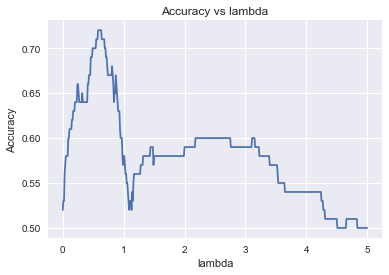

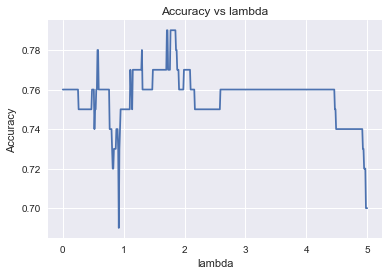

In [19]:
plt.xlabel("lambda")
plt.ylabel("Accuracy")
plt.title("Accuracy vs lambda")
plt.plot(lambd_list,acc_list_list[0])
plt.show()

plt.xlabel("lambda")
plt.ylabel("Accuracy")
plt.title("Accuracy vs lambda")
plt.plot(lambd_list,acc_list_list[1])
plt.show()

In [37]:
#Q12,19
acc_rf1 = acc_list_list[0]
acc_rf2 = acc_list_list[1]
index1 = acc_rf1.index(max(acc_rf1))
print(max(acc_rf1))
index2 = acc_rf2.index(max(acc_rf2))
print(max(acc_rf2))

lmax1 = lambd_list[index1]
lmax2 = lambd_list[index2]
print(lmax1)
print(lmax2)

0.72
0.79
0.58
1.71


In [21]:
def getmatrix(R):
    R1 = np.zeros(shape=(10,10))
    k=0
    for i in range(0,10):
        for j in range(0,10):
            R1[j][i]=R[k]
            k=k+1
    return R1

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.1238e+02  2e+03  2e+00  2e+01  1e+00
 1: -2.6635e+02 -5.0305e+02  3e+03  2e+00  1e+01  2e+00
 2: -1.3431e+03 -1.6023e+03  1e+04  2e+00  1e+01  6e+00
 3: -1.3276e+04 -1.3573e+04  1e+05  2e+00  2e+01  5e+01
 4: -1.1278e+06 -1.1246e+06  8e+06  2e+00  2e+01  4e+03
 5: -1.1282e+08 -1.1246e+08  8e+08  2e+00  2e+01  4e+05
Certificate of dual infeasibility found.


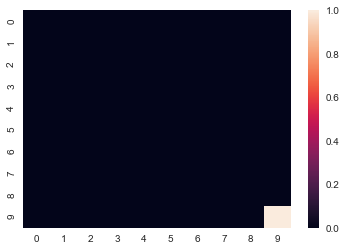

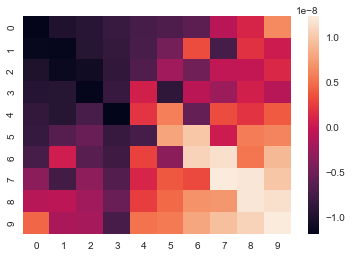

In [22]:
#Q13
C,D,B = getmatrices(Oe,alist,0,gamma,lmax1,maximum)
R = getrewardfunc(C,D,B)
getheatmap(rf1)

R1 = getmatrix(R)
getheatmap(R1)

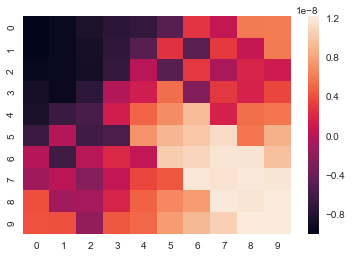

In [23]:
#Q14
v1=optimal_value(ss,action,w,gamma,R1,right,left,up,down)
v_new1=np.transpose(v1.reshape(10,10))
getheatmap(v_new1)

In [24]:
#Q16
v1,a1=optimal_policy(ss,action,w,gamma,R1,right,left,up,down)
print a1  
    
ar1=getarrows(a1)
ar1=np.transpose(np.asarray(ar1).reshape(10,10))
for i in range(0,10):
    print reduce(lambda x,y : x+ "\t" + y,ar1[i])

[ 0.  3.  3.  3.  3.  0.  3.  3.  3.  1.  0.  0.  3.  3.  3.  3.  0.  3.
  1.  1.  0.  0.  0.  0.  3.  3.  1.  3.  1.  1.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  3.  3.  0.  0.  0.  0.  0.  0.  3.  0.  0.  3.
  3.  0.  0.  0.  0.  0.  0.  3.  2.  3.  3.  3.  0.  0.  0.  0.  0.  0.
  0.  3.  3.  3.  3.  0.  2.  0.  0.  2.  2.  3.  3.  3.  3.  1.  2.  0.
  0.  2.  2.  3.  3.  3.  3.  1.  3.  0.]
→	→	→	→	→	↓	→	→	→	→
↓	→	→	→	→	→	↓	→	↑	↑
↓	↓	→	→	↓	→	↑	→	↑	↑
↓	↓	→	→	↓	↓	↓	↓	↓	↓
↓	↓	↓	→	→	↓	↓	↓	↓	↓
→	↓	↓	→	→	→	↓	↓	↓	↓
↓	→	←	→	→	→	→	↓	↓	↓
↓	↓	↓	→	→	→	→	→	←	←
↓	←	←	→	→	→	→	↑	↑	↓
←	←	←	→	→	→	→	→	→	→


     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -4.1283e+03  6e+03  2e-01  1e+01  1e+00
 1: -4.9112e+02 -3.0172e+03  5e+03  1e-01  9e+00  2e+00
 2: -7.7199e+03 -1.3333e+04  5e+04  3e-01  2e+01  1e+01
 3: -1.2356e+04 -1.8087e+04  7e+04  3e-01  2e+01  3e+01
 4: -4.8916e+04 -5.2743e+04  2e+05  2e-01  1e+01  7e+01
 5: -6.3144e+05 -6.3395e+05  2e+06  2e-01  1e+01  8e+02
 6: -6.2428e+07 -6.2350e+07  2e+08  2e-01  1e+01  8e+04
Certificate of dual infeasibility found.


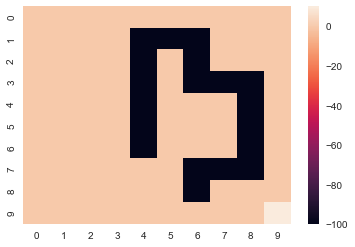

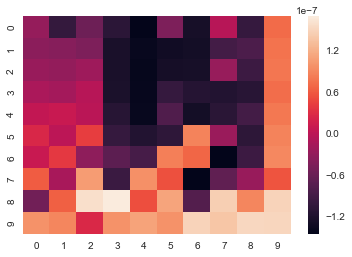

In [25]:
#Q20
C,D,B = getmatrices(Oe,alist,1,gamma,lmax2,maximum)
R = getrewardfunc(C,D,B)
getheatmap(rf2)

R2 = getmatrix(R)
getheatmap(R2)

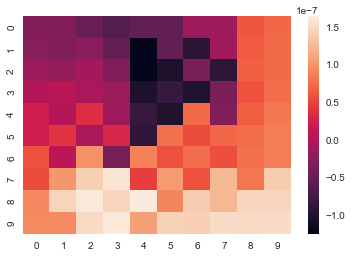

In [26]:
#Q21
v2=optimal_value(ss,action,w,gamma,R2,right,left,up,down)
v_new2=np.transpose(v2.reshape(10,10))
getheatmap(v_new2)

In [27]:
#Q23
v2,a2=optimal_policy(ss,action,w,gamma,R2,right,left,up,down)
print a2  
    
ar2=getarrows(a2)
ar2=np.transpose(np.asarray(ar2).reshape(10,10))
for i in range(0,10):
    print reduce(lambda x,y : x+ "\t" + y,ar2[i])

[ 1.  3.  3.  3.  3.  3.  3.  1.  0.  1.  1.  3.  3.  3.  3.  3.  3.  0.
  0.  2.  3.  3.  3.  3.  3.  3.  3.  3.  0.  2.  1.  1.  1.  1.  1.  1.
  1.  3.  1.  2.  0.  1.  1.  1.  1.  3.  3.  3.  1.  1.  2.  2.  0.  3.
  3.  3.  3.  3.  3.  0.  0.  0.  0.  3.  3.  3.  1.  1.  3.  3.  2.  2.
  0.  0.  3.  1.  1.  3.  3.  0.  0.  0.  0.  0.  0.  0.  0.  3.  3.  0.
  3.  3.  0.  3.  3.  3.  3.  3.  3.  0.]
←	←	↓	←	→	↑	→	↑	→	↓
↓	↓	↓	←	←	↑	→	↑	→	↓
↓	↓	↓	←	←	→	→	→	→	→
↓	↓	↓	←	←	↓	↓	→	→	↓
↓	↓	↓	←	←	↓	↓	↓	→	↓
↓	↓	↓	←	↓	↓	↓	←	→	↓
↓	↓	↓	←	↓	↓	←	←	→	↓
←	→	↓	↓	↓	↓	←	↓	↓	↓
→	→	→	←	←	↓	↓	↓	↓	↓
←	↑	↑	↑	←	→	↓	→	→	→
